In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sdrudp.resample import resample

We inject a tone with known frequency $\nu$. If the sampling rate of the ADC $f_s^{\rm ADC}$ differs from the desired (master) sampling rate $f_s$, there will be a phase difference:

$$V(t) = e^{i2\pi\nu t},\, V_{\rm ADC}(t) = e^{i2\pi\nu t_{\rm ADC}} \\
e^{i \Delta \phi} = V_{\rm ADC}V^* = e^{i2\pi\nu (t_{\rm ADC}-t)} \\
\Delta \phi = 2\pi\nu (t_{\rm ADC}-t) = 2\pi\nu t \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right)$$

If there's also some phase difference $\phi_0$ at $t=0$, we get:
$$\Delta \phi = 2\pi\nu t \left(\frac{f_s}{f_s^{\rm ADC}} - 1\right) + \phi_0$$

Thus, if we measure the phase difference, we can recover the sampling rate of the ADC:
$$\frac{f_s}{f_s^{\rm ADC}} - 1 = \frac{\Delta \phi-\phi_0}{2\pi\nu t} \\
f_s^{\rm ADC} = f_s \frac{2\pi\nu t}{\Delta \phi-\phi_0 + 2\pi\nu t}$$

Note that $\Delta \phi$ by defintion is between $-\pi$ and $\pi$, so we need to unwrap $\Delta \phi$ (i.e., add multiples of $2\pi$ using ``np.unwrap``) before applying the formula above.

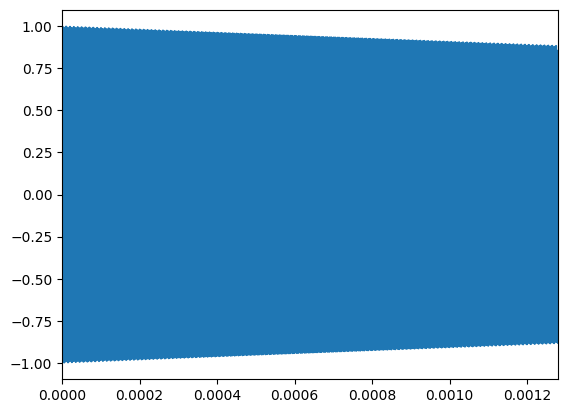

In [2]:
NSAMPLES = 4096
TONE = 901.5e6
LO = 901e6
SAMPLE_RATE = 3.2e6
t = np.arange(NSAMPLES) / SAMPLE_RATE
omega = 2 * np.pi * (TONE - LO)
tone_cos = np.cos(omega * t)
tone_sin = -np.sin(omega * t)  # conjugate

sample_fq = 3.200105e6
OFFSET = np.pi/3
re = np.cos(omega * t * SAMPLE_RATE / sample_fq + OFFSET)
im = np.sin(omega * t * SAMPLE_RATE / sample_fq + OFFSET)
data = np.array([re, im]).T
data = np.expand_dims(data, axis=0)  # add block axis (with nblocks=1)

plt.figure()
plt.plot(t, tone_cos-re)
plt.xlim(t.min(), t.max())
plt.show().

In [3]:
data = data - np.mean(data, axis=1, keepdims=True)  # remove DC offset
real = data[0, :, 0]
imag = data[0, :, 1]
data_cos = real * tone_cos - imag * tone_sin  # real part (real*real - im*im)
data_sin = real * tone_sin + imag * tone_cos  # imaginary (real*im + im*real)
dphi = np.arctan2(data_sin, data_cos) # phase difference in units of radians
dphi -= dphi[0]
# dt = dphi / (2 * np.pi * (TONE - LO))  # phase difference in units of seconds
# dsamp = dt * SAMPLE_RATE  # phase difference in units of sample number

# recover the ADC sample rate
den = np.unwrap(dphi) + omega * t
nonzero = den != 0
sample_ADC = np.mean(SAMPLE_RATE * omega * t[nonzero] / den[nonzero])
print(sample_ADC / sample_fq)  # how close we are to the true ADC sampling rate

0.9999999681248691


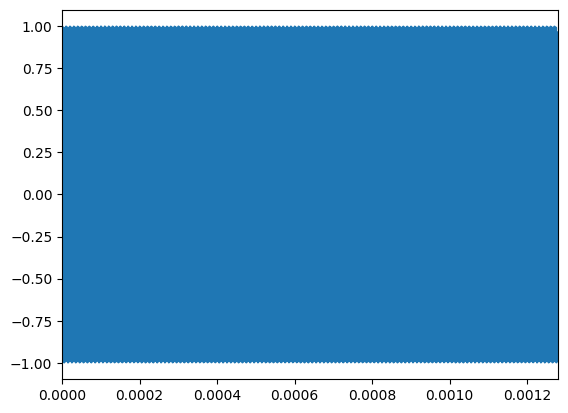

In [4]:
resamp_real = resample(real, sample_ADC, SAMPLE_RATE)
resamp_imag = resample(imag, sample_ADC, SAMPLE_RATE)

plt.figure()
plt.plot(t, tone_cos - resamp_real)
plt.xlim(t.min(), t.max())
plt.show()

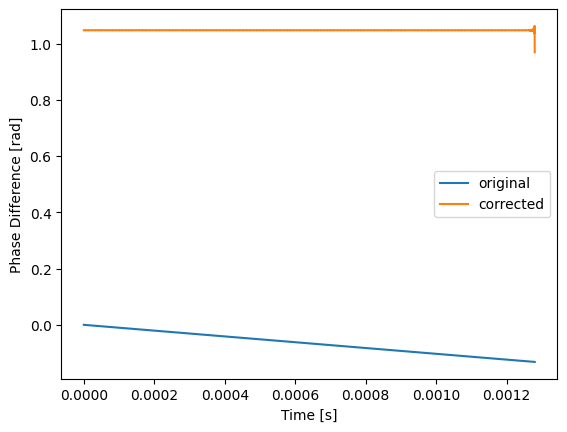

In [5]:
rs_cos = resamp_real * tone_cos - resamp_imag * tone_sin
rs_sin = resamp_real * tone_sin + resamp_imag * tone_cos
rs_dphi = np.arctan2(rs_sin, rs_cos)

plt.figure()
plt.plot(t, dphi, label="original")
plt.plot(t, rs_dphi, label="corrected")
plt.ylabel("Phase Difference [rad]")
plt.xlabel("Time [s]")
plt.legend()
plt.show()

## Real data

In [47]:
d = np.load("../data.npz")
data = d["data"][1:, 0]
rs_data = np.swapaxes(d["rs_data"][1:], 1, 2)
dphi = d["dphi"][1:]
rs_dphi = d["rs_dphi"][1:]
#rs_dphi -= np.expand_dims(rs_dphi[:, 0], axis=1)
NSAMPLES = data.shape[1]
t = t[:NSAMPLES]

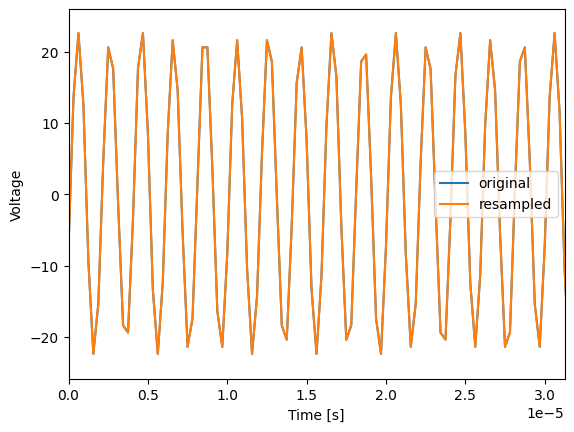

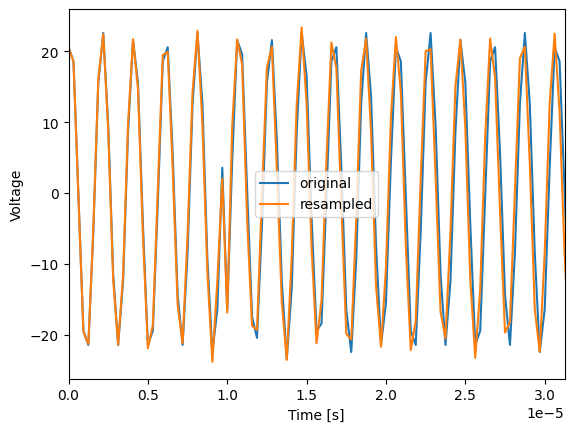

In [57]:
for i in range(2):
    plt.figure()
    plt.plot(t[:NSAMPLES], data[i, :, 0], label="original")
    plt.plot(t[:NSAMPLES], rs_data[i, :, 0], label="resampled")
    plt.ylabel("Voltage")
    plt.xlabel("Time [s]")
    plt.legend()
    plt.xlim(0, t[100])
    plt.show()

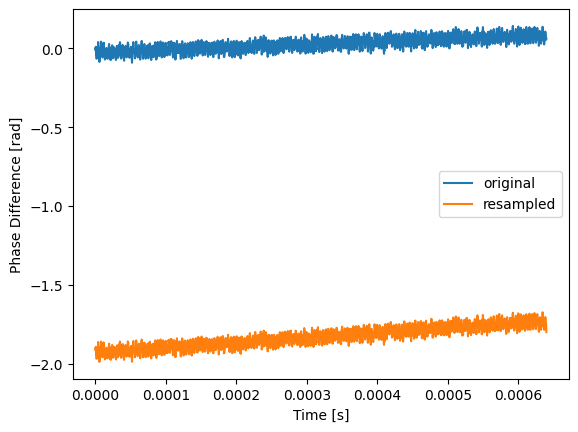

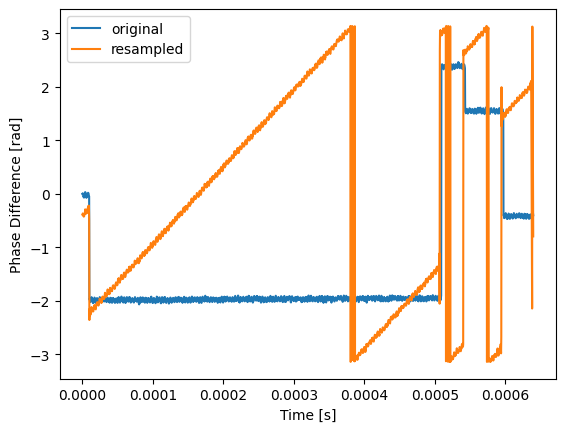

In [56]:
for i in range(2):
    plt.figure()
    plt.plot(t[:NSAMPLES], dphi[i], label="original")
    plt.plot(t[:NSAMPLES], rs_dphi[i], label="resampled")
    plt.ylabel("Phase Difference [rad]")
    plt.xlabel("Time [s]")
    plt.legend()
    plt.show()

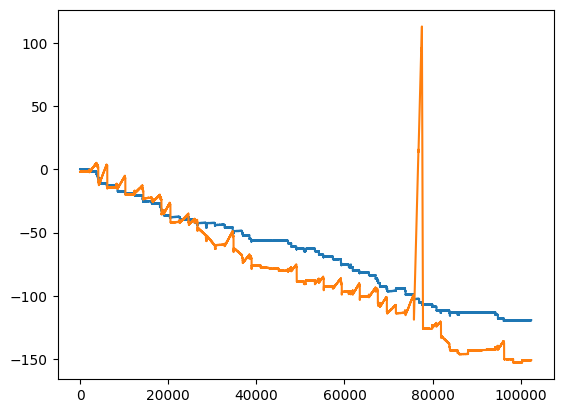

In [58]:
plt.figure()
plt.plot(np.unwrap(dphi.ravel()))
plt.plot(np.unwrap(rs_dphi.ravel()))
plt.show()